# Analyze the sound of a track

In [54]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Load the MP3 file
audio_path = 'Katy Perry - Last Friday Night (T.G.I.F.).mp3'  # Replace with your MP3 file path
y, sr = librosa.load(audio_path)

# Compute the spectrogram
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

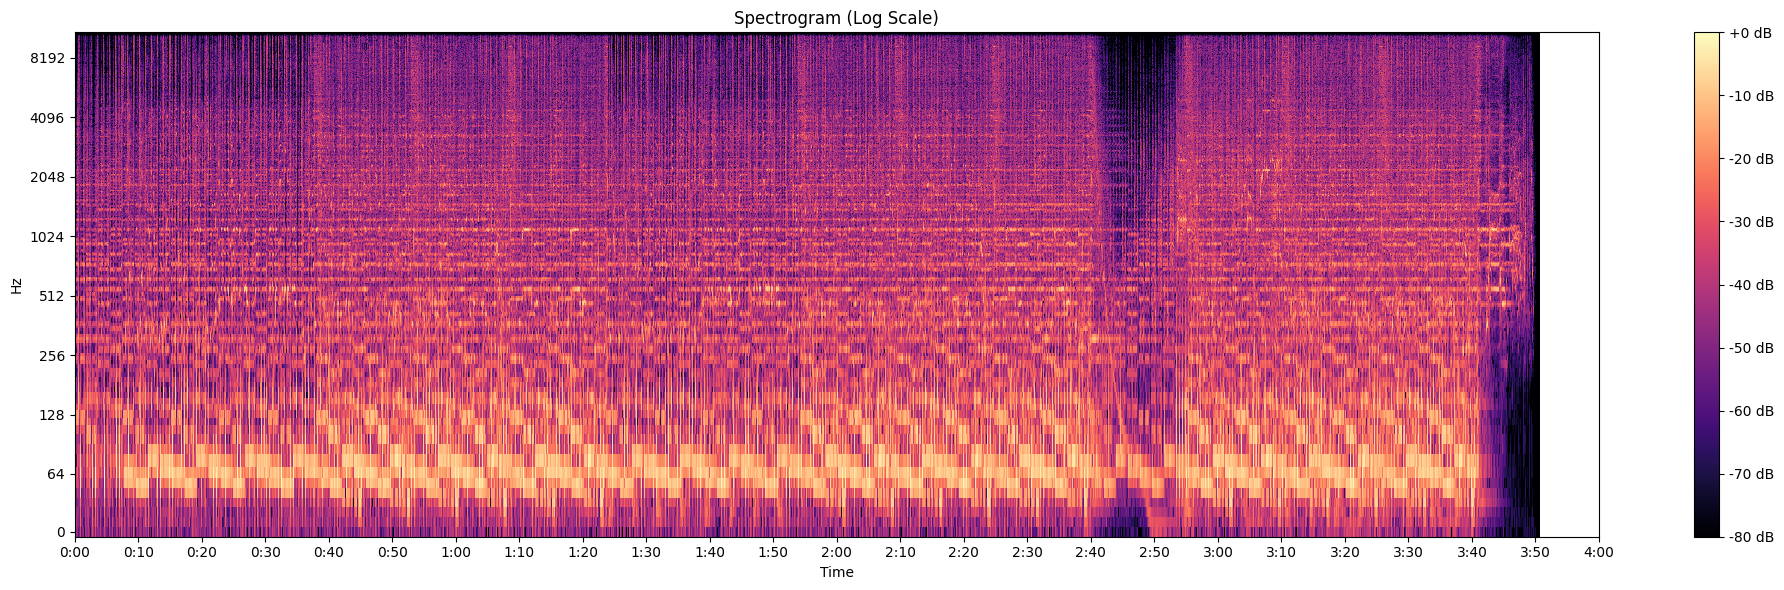

In [55]:
plt.figure(figsize=(20, 6))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram (Log Scale)')

# Set x-axis ticks every 10 seconds
duration = librosa.get_duration(y=y, sr=sr)
plt.xticks(np.arange(0, duration + 10, 10))

plt.tight_layout()
plt.show()

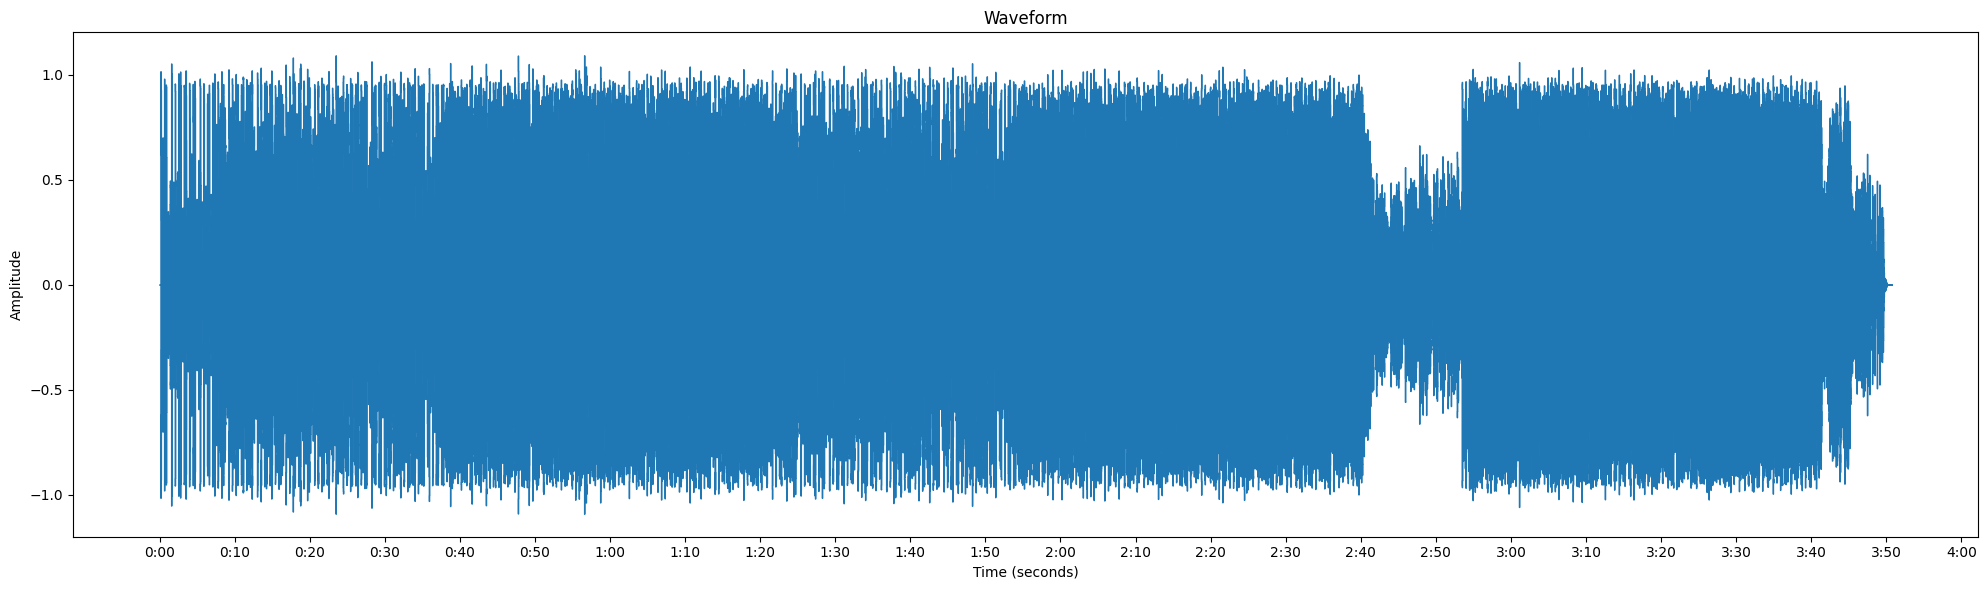

In [56]:
plt.figure(figsize=(20, 6))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')

# Set x-axis ticks every 10 seconds
plt.xticks(np.arange(0, duration + 10, 10))

plt.tight_layout()
plt.show()

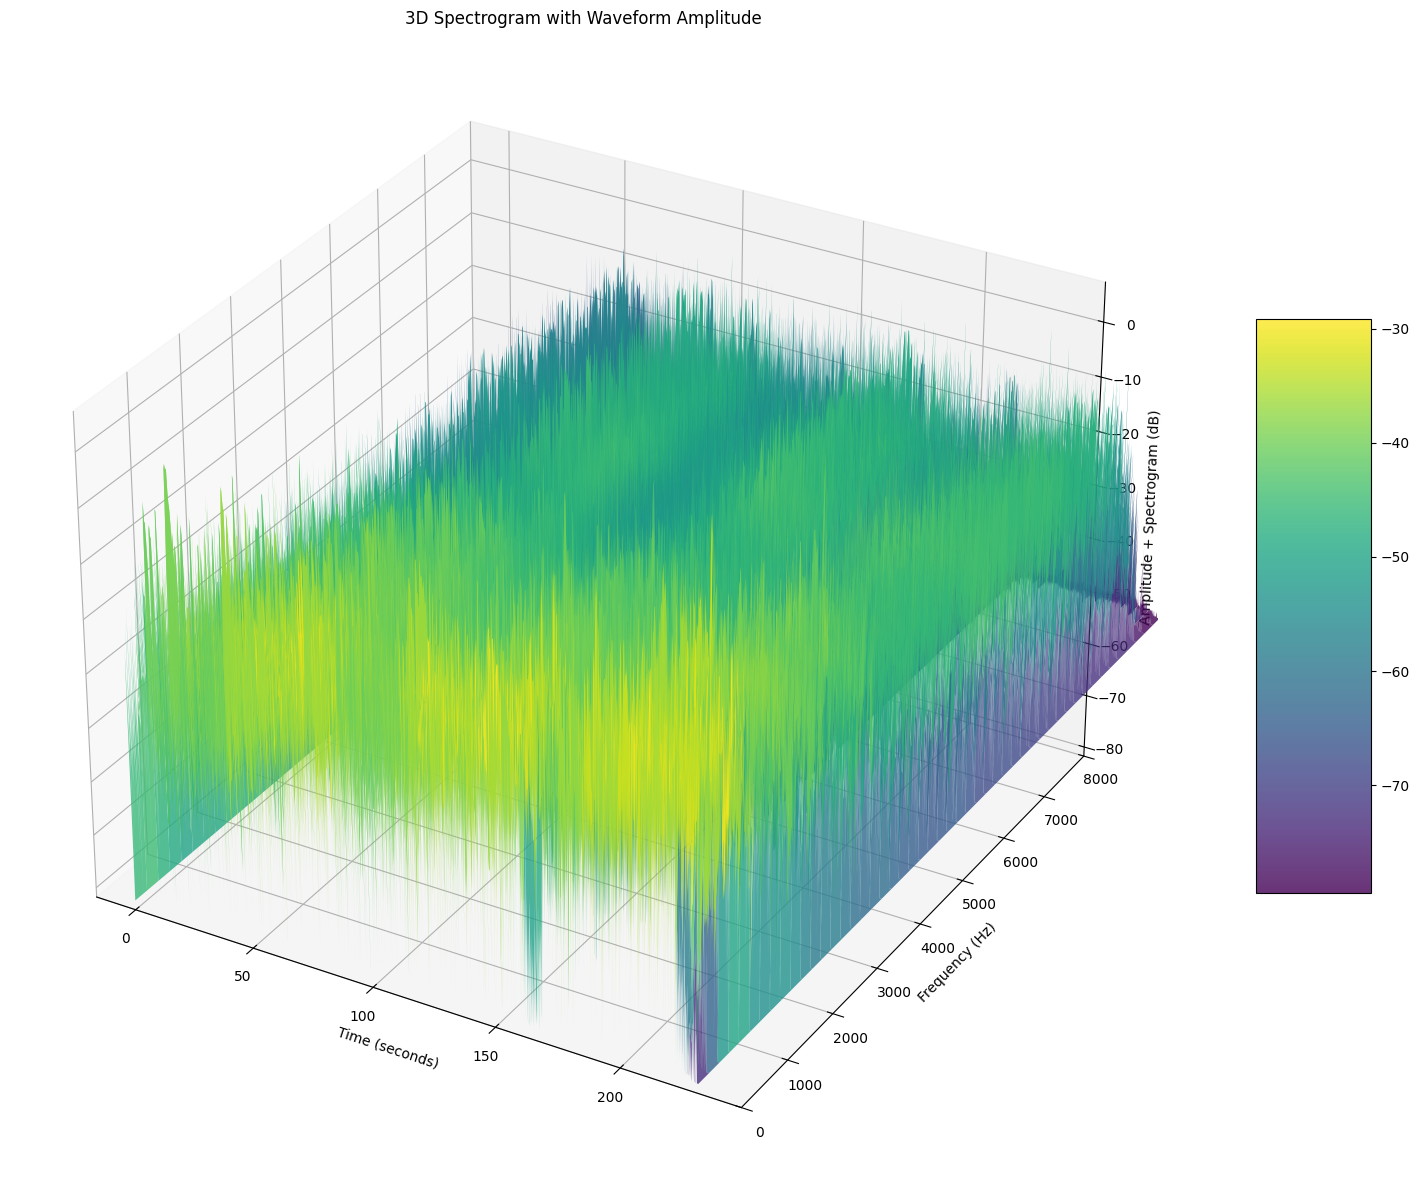

In [57]:
from mpl_toolkits.mplot3d import Axes3D

# Downsample the waveform to match spectrogram time resolution
hop_length = 512
frame_length = len(y) // D.shape[1]
y_frames = np.array([np.mean(np.abs(y[i*hop_length:(i+1)*hop_length])) for i in range(D.shape[1])])

# Create time and frequency axes
times = librosa.frames_to_time(np.arange(D.shape[1]), sr=sr, hop_length=hop_length)
freqs = librosa.fft_frequencies(sr=sr, n_fft=2048)

# Create meshgrid for 3D plot
T, F = np.meshgrid(times, freqs)

# Create 3D plot
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot spectrogram as surface with waveform as height
# Normalize waveform amplitude to scale appropriately
Z = np.tile(y_frames, (D.shape[0], 1)) * 10  # Scale factor for visibility

surf = ax.plot_surface(T, F, D + Z, cmap='viridis', alpha=0.8)

ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Frequency (Hz)')
ax.set_zlabel('Amplitude + Spectrogram (dB)')
ax.set_title('3D Spectrogram with Waveform Amplitude')
ax.set_ylim([0, 8000])  # Limit frequency range for better visualization

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.tight_layout()
plt.show()

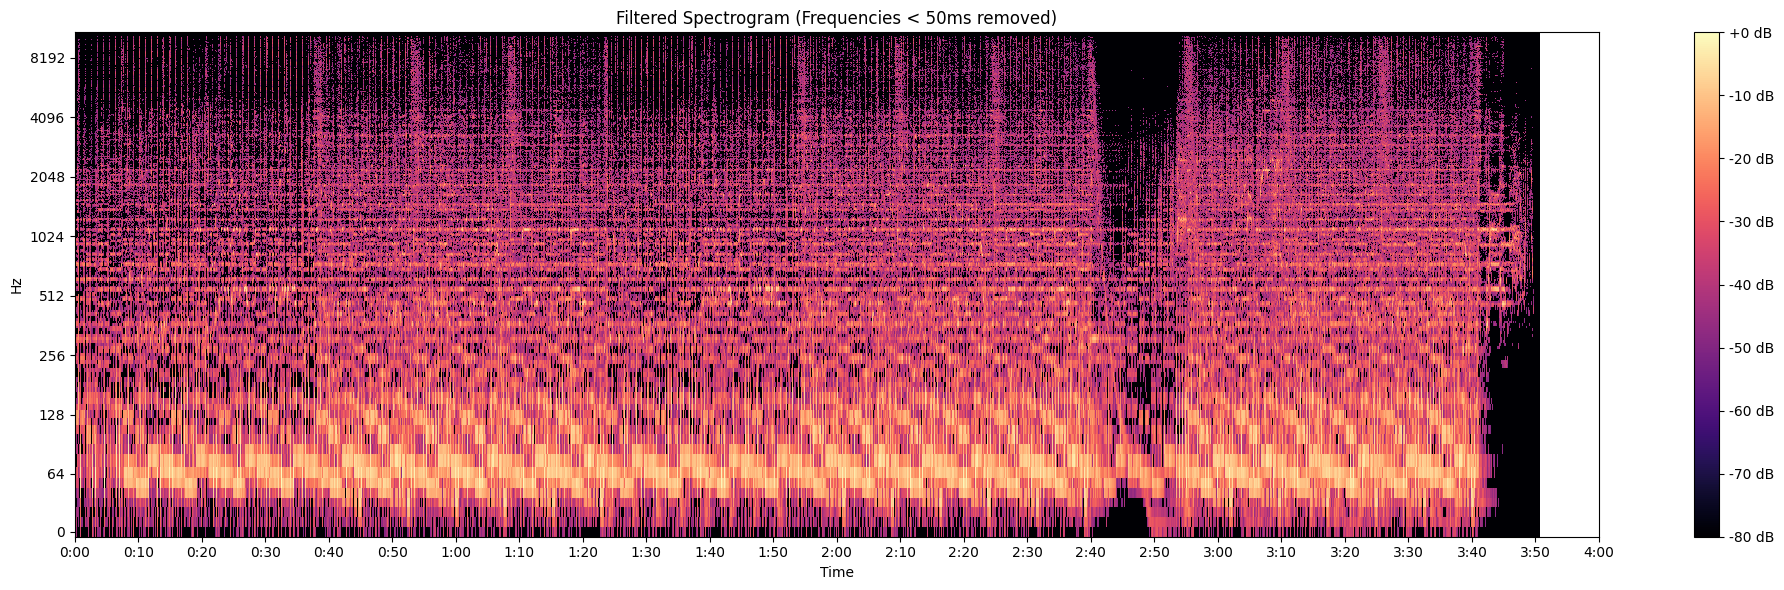

In [58]:
from scipy.ndimage import binary_opening

# Calculate the minimum number of consecutive frames for 50ms
min_duration_ms = 100
min_frames = int((min_duration_ms / 1000) * sr / hop_length)

# Create a binary mask for frequencies above a threshold (e.g., -60 dB)
threshold_db = -50
binary_mask = D > threshold_db

# Apply morphological opening to remove short-duration frequency components

# Create a structuring element (horizontal line of min_frames length)
structure = np.ones((1, min_frames), dtype=bool)

# Apply opening operation to filter out short-duration frequencies
filtered_mask = binary_opening(binary_mask, structure=structure)

# Apply the mask to the spectrogram
D_filtered = np.where(filtered_mask, D, -80)

# Plot the filtered spectrogram
plt.figure(figsize=(20, 6))
librosa.display.specshow(D_filtered, sr=sr, x_axis='time', y_axis='log', hop_length=hop_length)
plt.colorbar(format='%+2.0f dB')
plt.title('Filtered Spectrogram (Frequencies < 50ms removed)')

# Set x-axis ticks every 10 seconds
plt.xticks(np.arange(0, duration + 10, 10))

plt.tight_layout()
plt.show()

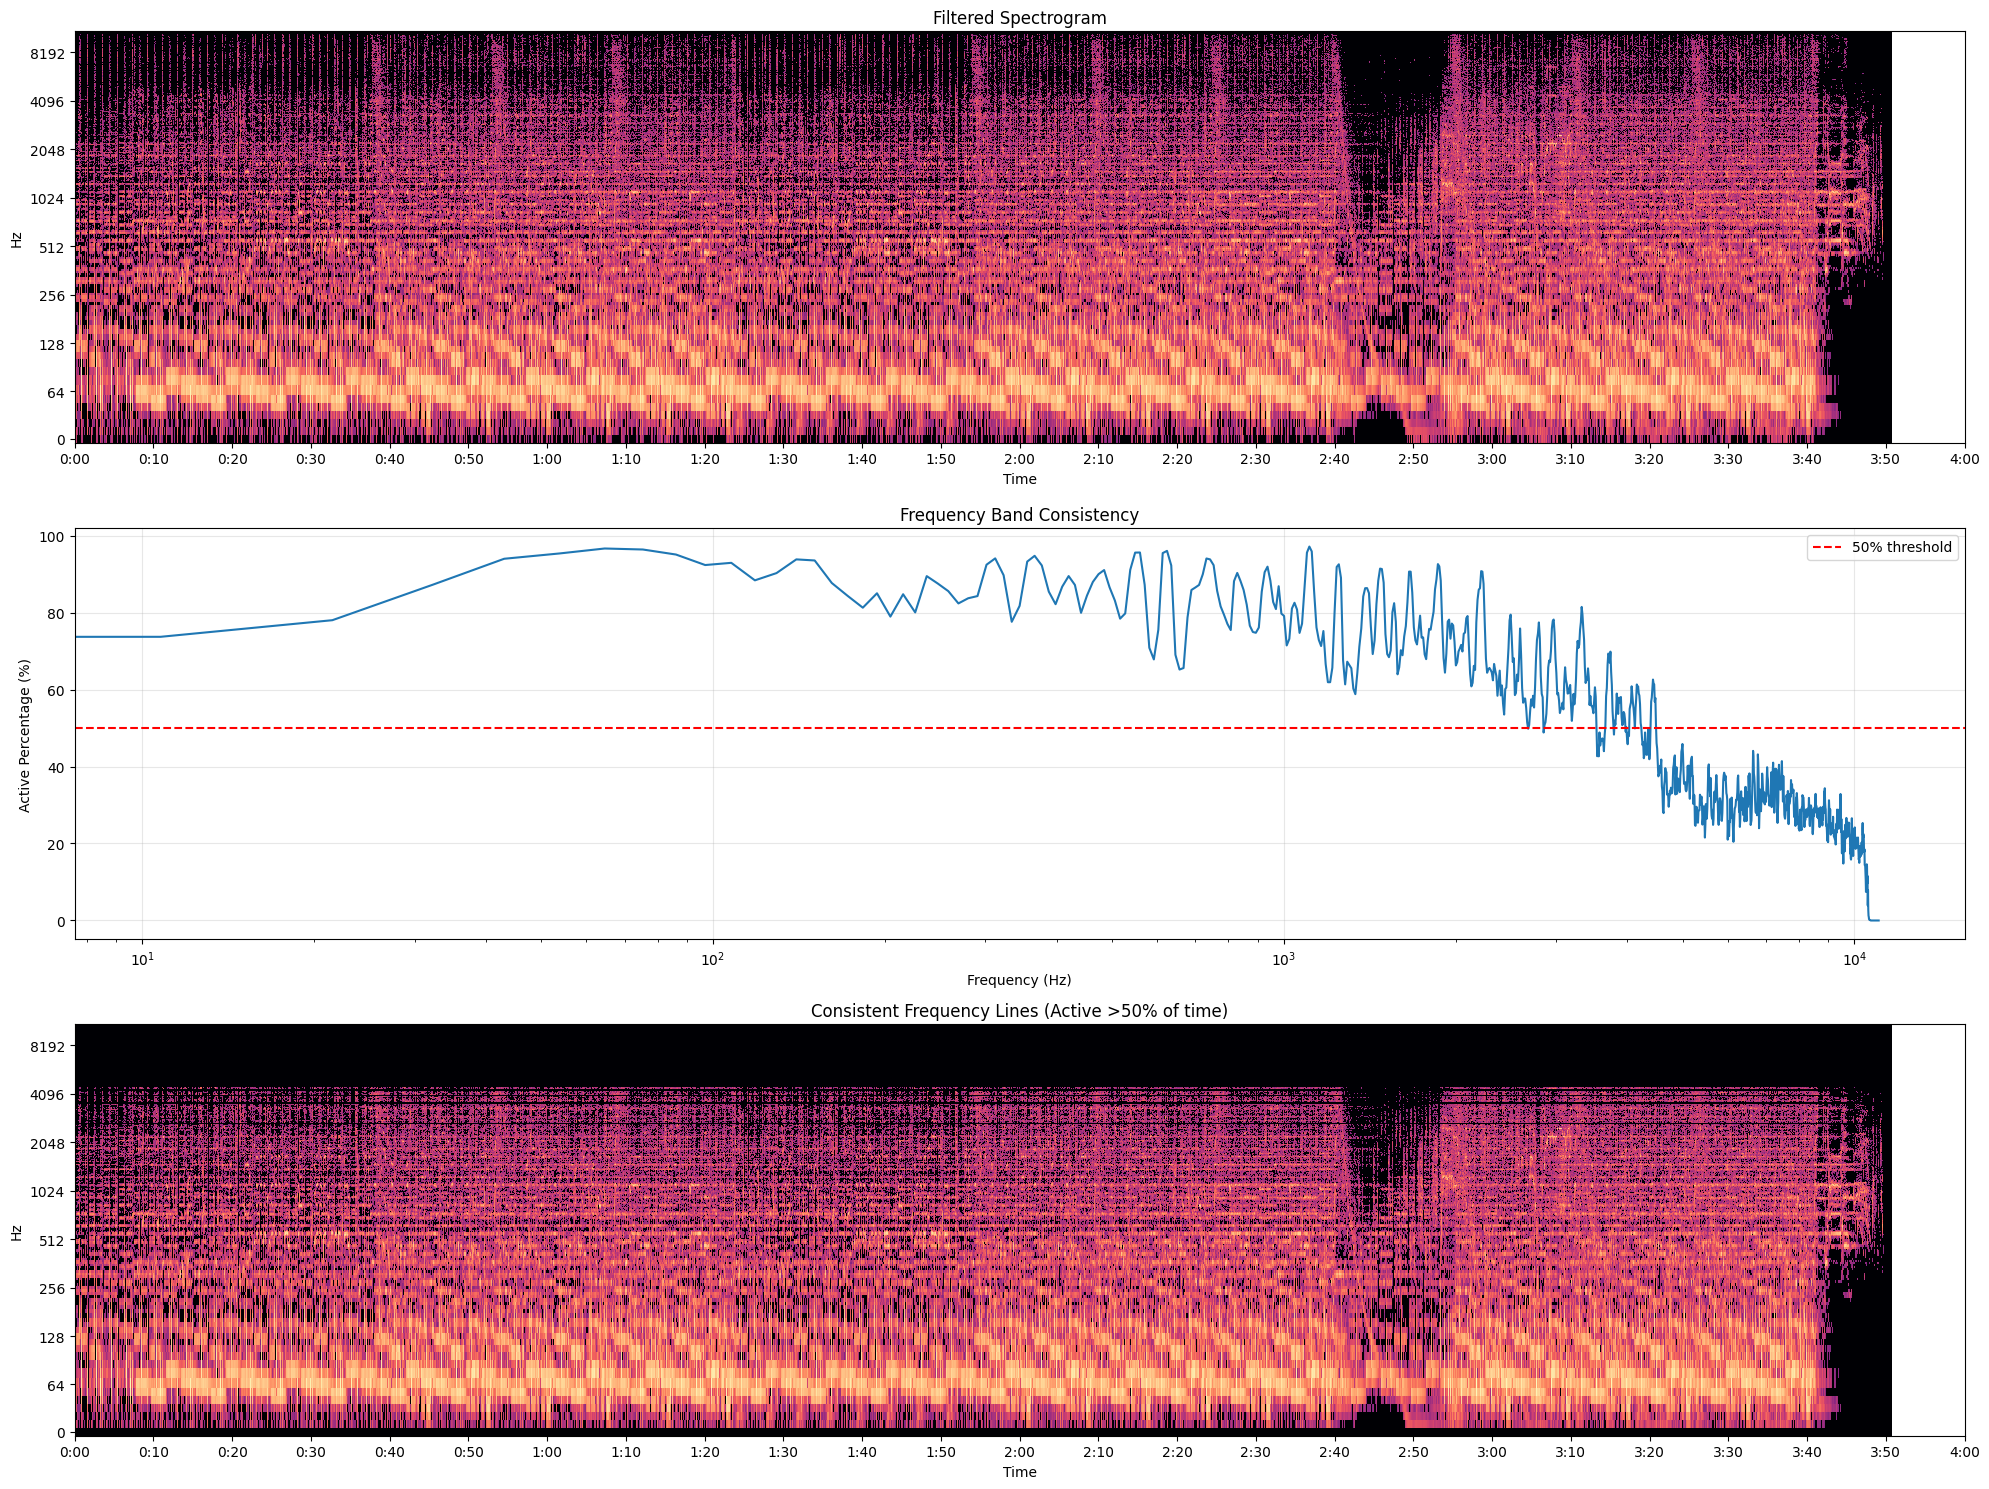

Found 383 consistent frequency bands (>50% active)
Frequency range: 10.77 Hz - 4489.67 Hz

Consistent frequencies:
  10.77 Hz (active 73.7% of time)
  21.53 Hz (active 78.0% of time)
  32.30 Hz (active 87.2% of time)
  43.07 Hz (active 94.0% of time)
  53.83 Hz (active 95.3% of time)
  64.60 Hz (active 96.6% of time)
  75.37 Hz (active 96.4% of time)
  86.13 Hz (active 95.1% of time)
  96.90 Hz (active 92.3% of time)
  107.67 Hz (active 92.9% of time)
  118.43 Hz (active 88.4% of time)
  129.20 Hz (active 90.2% of time)
  139.97 Hz (active 93.8% of time)
  150.73 Hz (active 93.5% of time)
  161.50 Hz (active 87.7% of time)
  172.27 Hz (active 84.3% of time)
  183.03 Hz (active 81.3% of time)
  193.80 Hz (active 85.0% of time)
  204.57 Hz (active 78.9% of time)
  215.33 Hz (active 84.7% of time)
  226.10 Hz (active 80.0% of time)
  236.87 Hz (active 89.5% of time)
  247.63 Hz (active 87.5% of time)
  258.40 Hz (active 85.6% of time)
  269.17 Hz (active 82.4% of time)
  279.93 Hz (active

In [59]:
# Identify frequency bands that are consistently present (horizontal "lines" in spectrogram)
# These are frequencies that appear for most of the track duration

# Define threshold for considering a frequency "active" at a given time
active_threshold_db = -50

# Create mask for active frequencies
active_mask = D_filtered > active_threshold_db

# Calculate percentage of time each frequency band is active
active_percentage_per_freq = np.mean(active_mask, axis=1) * 100

# Identify frequency bands that are active for a high percentage of time (e.g., >80%)
consistency_threshold = 50  # percentage
consistent_freq_indices = np.where(active_percentage_per_freq > consistency_threshold)[0]
consistent_freqs = freqs[consistent_freq_indices]

# Create a mask highlighting only these consistent frequency lines
consistent_lines_mask = np.zeros_like(D_filtered, dtype=bool)
consistent_lines_mask[consistent_freq_indices, :] = active_mask[consistent_freq_indices, :]

# Apply mask to show only consistent frequencies
D_consistent_lines = np.where(consistent_lines_mask, D_filtered, -80)

# Visualize
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 15))

# Plot 1: Original filtered spectrogram
librosa.display.specshow(D_filtered, sr=sr, x_axis='time', y_axis='log', hop_length=hop_length, ax=ax1)
ax1.set_title('Filtered Spectrogram')
ax1.set_xticks(np.arange(0, duration + 10, 10))

# Plot 2: Frequency consistency over time (percentage)
ax2.plot(freqs, active_percentage_per_freq)
ax2.axhline(y=consistency_threshold, color='r', linestyle='--', label=f'{consistency_threshold}% threshold')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Active Percentage (%)')
ax2.set_title('Frequency Band Consistency')
ax2.set_xscale('log')
ax2.grid(True, alpha=0.3)
ax2.legend()

# Plot 3: Isolated consistent frequency lines
librosa.display.specshow(D_consistent_lines, sr=sr, x_axis='time', y_axis='log', hop_length=hop_length, ax=ax3)
ax3.set_title(f'Consistent Frequency Lines (Active >{consistency_threshold}% of time)')
ax3.set_xticks(np.arange(0, duration + 10, 10))

plt.tight_layout()
plt.show()

# Print summary
print(f"Found {len(consistent_freqs)} consistent frequency bands (>{consistency_threshold}% active)")
if len(consistent_freqs) > 0:
    print(f"Frequency range: {consistent_freqs.min():.2f} Hz - {consistent_freqs.max():.2f} Hz")
    print(f"\nConsistent frequencies:")
    for freq in consistent_freqs:
        idx = np.where(freqs == freq)[0][0]
        print(f"  {freq:.2f} Hz (active {active_percentage_per_freq[idx]:.1f}% of time)")